# GPyTorch implementation of Bayesian GP-LVM ([Titsias and Lawrence, 2010](http://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf))

## Introduction
This implementation is a modification of code from the [Bayesian GP-LVM in GPflow](https://gpflow.readthedocs.io/en/master/_modules/gpflow/models/gplvm.html#BayesianGPLVM) using the [psi statistics implemented in GPy](https://gpy.readthedocs.io/en/deploy/GPy.kern.src.psi_comp.html#module-GPy.kern.src.psi_comp.rbf_psi_comp). Derivations documenting the GPflow implementation can be found [here](http://www.gatsby.ucl.ac.uk/~rapela/gplvm/gplvm.pdf).

In [1]:
# Standard imports
import sys
import os.path
import numpy as np
import torch
import gpytorch

import matplotlib.pyplot as plt

sys.path.append("../src")

import models
import stats
import utilities

## Parameters definitions:

In [2]:
latent_dim = 10  # number of latent dimensions
num_inducing = 50  # number of inducing pts
variational_var0 = 0.5 # initial value for variational variance
kernel_output_scale0 = 1.0
likelihood_var0 = 0.01
lengthscale0 = 1.0
lr = 1.0 # learning rate
max_iter = 10000
line_search_fn = "strong_wolfe" # linear search function for LBFGS

## Set up training data

In [3]:
import urllib.request
import tarfile

url = "http://staffwww.dcs.shef.ac.uk/people/N.Lawrence/resources/3PhData.tar.gz"
urllib.request.urlretrieve(url, '3PhData.tar.gz')
with tarfile.open('3PhData.tar.gz', 'r') as f:
    f.extract('DataTrn.txt')
    f.extract('DataTrnLbls.txt')

Y = torch.tensor(np.loadtxt(fname='DataTrn.txt'), dtype=torch.double) 
labels = torch.Tensor(np.loadtxt(fname='DataTrnLbls.txt'))
labels = (labels @ np.diag([1, 2, 3])).sum(axis=1)

## Defining the GPLVM model

In [4]:
num_data = Y.shape[0]  # number of data points                             
X_mean_init = stats.pca_reduce(X=Y, latent_dim=latent_dim)
X_var_init = variational_var0*torch.ones((num_data, latent_dim), dtype=torch.double)
likelihood_var = torch.tensor(likelihood_var0, dtype=torch.double)
torch.manual_seed(1)  # for reproducibility
inducing_variable = X_mean_init[torch.randperm(n=X_mean_init.shape[0])][:num_inducing]
lengthscales = torch.tensor([lengthscale0]*latent_dim, dtype=torch.double)
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=latent_dim))
kernel.outputscale = torch.tensor([kernel_output_scale0], dtype=torch.double)
kernel.base_kernel.lengthscale = lengthscales
gplvm = models.BayesianGPLVM(
    data=Y,
    variational_mean=X_mean_init,
    variational_var=X_var_init,
    kernel=kernel,
    inducing_variable=inducing_variable,
    likelihood_var = likelihood_var,
)
gplvm = gplvm.double()

## Training the model

In [5]:
x = gplvm.parameters()
optimizer = torch.optim.LBFGS(x, lr=lr, max_iter=max_iter, line_search_fn=line_search_fn)
elbo_list = np.empty(10*max_iter, dtype=np.double)
elbo_list[:] = np.NaN
def optimize():
    iter_nro = 0
    def closure():
        nonlocal iter_nro
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        cur_eval = -gplvm.elbo()
        if cur_eval.requires_grad:
            cur_eval.backward(retain_graph=True)
        print("ELBO: {:f}, iter: {:d}".format(-cur_eval, iter_nro))
        elbo_list[iter_nro] = -cur_eval
        iter_nro += 1
        return cur_eval
    optimizer.step(closure)
optimize()    

/nfs/ghome/live/rapela/dev/research/gatsby-swc/gatsby/svGPFA/gplvmPyTorch/repository/examples/../src/models.py:111: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  e_values, e_vectors = torch.eig(cov_uu)
/nfs/ghome/live/rapela/dev/research/gatsby-swc/gatsby/svGPFA/gplvmPyTorch/repository/examples/../src/models.py:116: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.c

ELBO: -692049.982407, iter: 0
ELBO: -496333.664505, iter: 1
ELBO: -206642.811054, iter: 2
ELBO: -109538.455817, iter: 3
ELBO: -52780.322133, iter: 4
ELBO: -30563.313742, iter: 5
ELBO: -19457.665639, iter: 6
ELBO: -15066.386257, iter: 7
ELBO: -12952.631898, iter: 8
ELBO: -11724.634791, iter: 9
ELBO: -10650.851091, iter: 10
ELBO: -9109.758696, iter: 11
ELBO: -7560.540118, iter: 12
ELBO: -6743.701575, iter: 13
ELBO: -6187.466329, iter: 14
ELBO: -6003.953041, iter: 15
ELBO: -5857.284265, iter: 16
ELBO: -5627.802224, iter: 17
ELBO: -5449.288429, iter: 18
ELBO: -4930.173764, iter: 19
ELBO: -4319.288289, iter: 20
ELBO: -3866.482300, iter: 21
ELBO: -3710.139776, iter: 22
ELBO: -3693.633179, iter: 23
ELBO: -3666.625829, iter: 24
ELBO: -3650.325465, iter: 25
ELBO: -3589.067470, iter: 26
ELBO: -3356.808948, iter: 27
ELBO: -2731.959134, iter: 28
ELBO: -2154.904161, iter: 29
ELBO: -2450.066133, iter: 30
ELBO: -1980.160048, iter: 31
ELBO: -2683.608239, iter: 32
ELBO: -1934.587492, iter: 33
ELBO: -17

ELBO: 7144.737430, iter: 288
ELBO: 7146.126025, iter: 289
ELBO: 7148.335955, iter: 290
ELBO: 7149.944460, iter: 291
ELBO: 7151.948392, iter: 292
ELBO: 7153.729585, iter: 293
ELBO: 7155.668367, iter: 294
ELBO: 7157.080184, iter: 295
ELBO: 7159.250570, iter: 296
ELBO: 7159.340837, iter: 297
ELBO: 7160.478704, iter: 298
ELBO: 7161.993928, iter: 299
ELBO: 7163.825512, iter: 300
ELBO: 7165.250816, iter: 301
ELBO: 7166.804488, iter: 302
ELBO: 7168.626632, iter: 303
ELBO: 7169.675120, iter: 304
ELBO: 7170.894883, iter: 305
ELBO: 7172.711874, iter: 306
ELBO: 7174.019899, iter: 307
ELBO: 7176.251696, iter: 308
ELBO: 7178.335804, iter: 309
ELBO: 7179.850098, iter: 310
ELBO: 7181.442337, iter: 311
ELBO: 7182.925948, iter: 312
ELBO: 7185.144419, iter: 313
ELBO: 7187.017946, iter: 314
ELBO: 7188.818134, iter: 315
ELBO: 7190.393292, iter: 316
ELBO: 7192.341603, iter: 317
ELBO: 7194.058023, iter: 318
ELBO: 7195.479034, iter: 319
ELBO: 7197.356903, iter: 320
ELBO: 7198.629996, iter: 321
ELBO: 7200.127

ELBO: 7388.115932, iter: 573
ELBO: 7388.395678, iter: 574
ELBO: 7388.905503, iter: 575
ELBO: 7389.195447, iter: 576
ELBO: 7389.777065, iter: 577
ELBO: 7390.111809, iter: 578
ELBO: 7390.606022, iter: 579
ELBO: 7391.102946, iter: 580
ELBO: 7391.832410, iter: 581
ELBO: 7392.209028, iter: 582
ELBO: 7392.598750, iter: 583
ELBO: 7393.108185, iter: 584
ELBO: 7393.603474, iter: 585
ELBO: 7393.929922, iter: 586
ELBO: 7394.362659, iter: 587
ELBO: 7394.743785, iter: 588
ELBO: 7395.203453, iter: 589
ELBO: 7395.811016, iter: 590
ELBO: 7396.214950, iter: 591
ELBO: 7396.644575, iter: 592
ELBO: 7397.578455, iter: 593
ELBO: 7397.830386, iter: 594
ELBO: 7398.372281, iter: 595
ELBO: 7398.762226, iter: 596
ELBO: 7399.202500, iter: 597
ELBO: 7399.769444, iter: 598
ELBO: 7400.200051, iter: 599
ELBO: 7400.607248, iter: 600
ELBO: 7400.902150, iter: 601
ELBO: 7401.280854, iter: 602
ELBO: 7401.819126, iter: 603
ELBO: 7402.305577, iter: 604
ELBO: 7402.654019, iter: 605
ELBO: 7403.106011, iter: 606
ELBO: 7403.438

ELBO: 7485.187632, iter: 857
ELBO: 7485.475610, iter: 858
ELBO: 7485.732078, iter: 859
ELBO: 7486.004535, iter: 860
ELBO: 7486.299085, iter: 861
ELBO: 7486.558186, iter: 862
ELBO: 7486.719182, iter: 863
ELBO: 7486.950128, iter: 864
ELBO: 7486.906780, iter: 865
ELBO: 7487.064625, iter: 866
ELBO: 7487.206281, iter: 867
ELBO: 7487.477153, iter: 868
ELBO: 7487.661268, iter: 869
ELBO: 7487.942083, iter: 870
ELBO: 7488.137455, iter: 871
ELBO: 7488.415475, iter: 872
ELBO: 7488.596161, iter: 873
ELBO: 7488.816415, iter: 874
ELBO: 7489.014083, iter: 875
ELBO: 7489.220944, iter: 876
ELBO: 7489.421077, iter: 877
ELBO: 7489.568345, iter: 878
ELBO: 7489.942569, iter: 879
ELBO: 7489.922794, iter: 880
ELBO: 7490.200385, iter: 881
ELBO: 7490.424915, iter: 882
ELBO: 7490.696458, iter: 883
ELBO: 7490.933325, iter: 884
ELBO: 7491.164574, iter: 885
ELBO: 7491.659336, iter: 886
ELBO: 7491.733871, iter: 887
ELBO: 7492.166194, iter: 888
ELBO: 7492.352265, iter: 889
ELBO: 7492.648983, iter: 890
ELBO: 7493.054

ELBO: 7561.461204, iter: 1136
ELBO: 7561.666681, iter: 1137
ELBO: 7561.829999, iter: 1138
ELBO: 7562.061183, iter: 1139
ELBO: 7562.497998, iter: 1140
ELBO: 7562.735453, iter: 1141
ELBO: 7563.165510, iter: 1142
ELBO: 7563.299734, iter: 1143
ELBO: 7563.437434, iter: 1144
ELBO: 7563.795334, iter: 1145
ELBO: 7564.161300, iter: 1146
ELBO: 7564.394697, iter: 1147
ELBO: 7564.483890, iter: 1148
ELBO: 7564.761419, iter: 1149
ELBO: 7565.289926, iter: 1150
ELBO: 7565.091648, iter: 1151
ELBO: 7565.394884, iter: 1152
ELBO: 7565.556454, iter: 1153
ELBO: 7565.648481, iter: 1154
ELBO: 7565.744264, iter: 1155
ELBO: 7565.906417, iter: 1156
ELBO: 7566.338051, iter: 1157
ELBO: 7564.509131, iter: 1158
ELBO: 7566.436882, iter: 1159
ELBO: 7566.648825, iter: 1160
ELBO: 7566.713923, iter: 1161
ELBO: 7566.774481, iter: 1162
ELBO: 7566.893269, iter: 1163
ELBO: 7567.053670, iter: 1164
ELBO: 7567.293937, iter: 1165
ELBO: 7567.692785, iter: 1166
ELBO: 7567.652315, iter: 1167
ELBO: 7567.861478, iter: 1168
ELBO: 7568

ELBO: 7623.283649, iter: 1412
ELBO: 7623.835846, iter: 1413
ELBO: 7624.088017, iter: 1414
ELBO: 7624.682671, iter: 1415
ELBO: 7624.991552, iter: 1416
ELBO: 7625.476227, iter: 1417
ELBO: 7625.813387, iter: 1418
ELBO: 7626.004931, iter: 1419
ELBO: 7626.351693, iter: 1420
ELBO: 7627.001671, iter: 1421
ELBO: 7627.614873, iter: 1422
ELBO: 7627.373895, iter: 1423
ELBO: 7627.865634, iter: 1424
ELBO: 7628.386129, iter: 1425
ELBO: 7628.825099, iter: 1426
ELBO: 7629.203957, iter: 1427
ELBO: 7629.572062, iter: 1428
ELBO: 7626.534511, iter: 1429
ELBO: 7629.650407, iter: 1430
ELBO: 7630.120327, iter: 1431
ELBO: 7630.789610, iter: 1432
ELBO: 7631.270365, iter: 1433
ELBO: 7631.522697, iter: 1434
ELBO: 7631.835757, iter: 1435
ELBO: 7632.202350, iter: 1436
ELBO: 7632.437374, iter: 1437
ELBO: 7632.951913, iter: 1438
ELBO: 7633.031698, iter: 1439
ELBO: 7633.671113, iter: 1440
ELBO: 7634.042601, iter: 1441
ELBO: 7634.622040, iter: 1442
ELBO: 7633.360061, iter: 1443
ELBO: 7634.748459, iter: 1444
ELBO: 7634

ELBO: 7753.024415, iter: 1687
ELBO: 7753.567535, iter: 1688
ELBO: 7754.222391, iter: 1689
ELBO: 7754.910374, iter: 1690
ELBO: 7755.363611, iter: 1691
ELBO: 7755.880465, iter: 1692
ELBO: 7756.694045, iter: 1693
ELBO: 7757.238343, iter: 1694
ELBO: 7757.763623, iter: 1695
ELBO: 7758.504346, iter: 1696
ELBO: 7758.953762, iter: 1697
ELBO: 7759.531714, iter: 1698
ELBO: 7760.130943, iter: 1699
ELBO: 7760.593771, iter: 1700
ELBO: 7761.234045, iter: 1701
ELBO: 7761.884447, iter: 1702
ELBO: 7762.495789, iter: 1703
ELBO: 7763.078381, iter: 1704
ELBO: 7763.768436, iter: 1705
ELBO: 7764.443714, iter: 1706
ELBO: 7765.076078, iter: 1707
ELBO: 7765.731391, iter: 1708
ELBO: 7766.390434, iter: 1709
ELBO: 7766.974192, iter: 1710
ELBO: 7767.584434, iter: 1711
ELBO: 7768.053216, iter: 1712
ELBO: 7768.674799, iter: 1713
ELBO: 7769.333702, iter: 1714
ELBO: 7769.801579, iter: 1715
ELBO: 7770.322313, iter: 1716
ELBO: 7771.097988, iter: 1717
ELBO: 7771.605769, iter: 1718
ELBO: 7772.062590, iter: 1719
ELBO: 7772

ELBO: 7902.249619, iter: 1961
ELBO: 7902.862763, iter: 1962
ELBO: 7903.233472, iter: 1963
ELBO: 7903.788098, iter: 1964
ELBO: 7904.258425, iter: 1965
ELBO: 7904.619746, iter: 1966
ELBO: 7905.096908, iter: 1967
ELBO: 7905.504710, iter: 1968
ELBO: 7905.907319, iter: 1969
ELBO: 7906.401674, iter: 1970
ELBO: 7906.770516, iter: 1971
ELBO: 7907.369231, iter: 1972
ELBO: 7907.863298, iter: 1973
ELBO: 7908.229489, iter: 1974
ELBO: 7908.777146, iter: 1975
ELBO: 7909.176508, iter: 1976
ELBO: 7909.694121, iter: 1977
ELBO: 7910.158646, iter: 1978
ELBO: 7910.515188, iter: 1979
ELBO: 7911.001345, iter: 1980
ELBO: 7911.675095, iter: 1981
ELBO: 7912.042962, iter: 1982
ELBO: 7912.552399, iter: 1983
ELBO: 7912.916693, iter: 1984
ELBO: 7913.490787, iter: 1985
ELBO: 7913.994119, iter: 1986
ELBO: 7914.368832, iter: 1987
ELBO: 7914.999737, iter: 1988
ELBO: 7915.532416, iter: 1989
ELBO: 7915.983118, iter: 1990
ELBO: 7916.390930, iter: 1991
ELBO: 7916.797907, iter: 1992
ELBO: 7917.448297, iter: 1993
ELBO: 7917

ELBO: 8069.055471, iter: 2236
ELBO: 8069.479410, iter: 2237
ELBO: 8069.981585, iter: 2238
ELBO: 8070.765065, iter: 2239
ELBO: 8070.125525, iter: 2240
ELBO: 8071.233281, iter: 2241
ELBO: 8072.150615, iter: 2242
ELBO: 8072.790287, iter: 2243
ELBO: 8073.564807, iter: 2244
ELBO: 8074.117667, iter: 2245
ELBO: 8074.616229, iter: 2246
ELBO: 8075.337738, iter: 2247
ELBO: 8075.793689, iter: 2248
ELBO: 8076.623837, iter: 2249
ELBO: 8077.313889, iter: 2250
ELBO: 8078.062345, iter: 2251
ELBO: 8078.581386, iter: 2252
ELBO: 8079.130562, iter: 2253
ELBO: 8079.705861, iter: 2254
ELBO: 8080.332329, iter: 2255
ELBO: 8080.898468, iter: 2256
ELBO: 8081.422265, iter: 2257
ELBO: 8081.882079, iter: 2258
ELBO: 8082.789130, iter: 2259
ELBO: 8083.194722, iter: 2260
ELBO: 8083.761717, iter: 2261
ELBO: 8084.407758, iter: 2262
ELBO: 8085.193480, iter: 2263
ELBO: 8085.794763, iter: 2264
ELBO: 8086.428851, iter: 2265
ELBO: 8087.028923, iter: 2266
ELBO: 8087.718625, iter: 2267
ELBO: 8088.468106, iter: 2268
ELBO: 8088

ELBO: 8207.868149, iter: 2513
ELBO: 8208.484579, iter: 2514
ELBO: 8208.743118, iter: 2515
ELBO: 8209.168810, iter: 2516
ELBO: 8209.537527, iter: 2517
ELBO: 8210.195284, iter: 2518
ELBO: 8210.533065, iter: 2519
ELBO: 8210.926761, iter: 2520
ELBO: 8211.451410, iter: 2521
ELBO: 8211.866480, iter: 2522
ELBO: 8212.409147, iter: 2523
ELBO: 8212.709460, iter: 2524
ELBO: 8213.079261, iter: 2525
ELBO: 8213.415265, iter: 2526
ELBO: 8214.046850, iter: 2527
ELBO: 8214.365792, iter: 2528
ELBO: 8214.720559, iter: 2529
ELBO: 8215.236392, iter: 2530
ELBO: 8215.571273, iter: 2531
ELBO: 8216.190355, iter: 2532
ELBO: 8216.481603, iter: 2533
ELBO: 8216.877884, iter: 2534
ELBO: 8217.360149, iter: 2535
ELBO: 8217.973873, iter: 2536
ELBO: 8218.392368, iter: 2537
ELBO: 8218.842358, iter: 2538
ELBO: 8219.294517, iter: 2539
ELBO: 8219.854554, iter: 2540
ELBO: 8220.429656, iter: 2541
ELBO: 8220.863618, iter: 2542
ELBO: 8221.340829, iter: 2543
ELBO: 8221.966964, iter: 2544
ELBO: 8222.560196, iter: 2545
ELBO: 8223

ELBO: 8310.341748, iter: 2790
ELBO: 8310.671240, iter: 2791
ELBO: 8311.156652, iter: 2792
ELBO: 8311.537653, iter: 2793
ELBO: 8311.866439, iter: 2794
ELBO: 8312.310653, iter: 2795
ELBO: 8312.597231, iter: 2796
ELBO: 8313.092957, iter: 2797
ELBO: 8313.178240, iter: 2798
ELBO: 8313.910777, iter: 2799
ELBO: 8314.145777, iter: 2800
ELBO: 8314.535144, iter: 2801
ELBO: 8315.012931, iter: 2802
ELBO: 8315.343174, iter: 2803
ELBO: 8315.836135, iter: 2804
ELBO: 8316.106795, iter: 2805
ELBO: 8316.473260, iter: 2806
ELBO: 8316.788011, iter: 2807
ELBO: 8317.367162, iter: 2808
ELBO: 8317.657625, iter: 2809
ELBO: 8317.984842, iter: 2810
ELBO: 8318.400680, iter: 2811
ELBO: 8318.889396, iter: 2812
ELBO: 8319.280291, iter: 2813
ELBO: 8319.696278, iter: 2814
ELBO: 8320.005137, iter: 2815
ELBO: 8320.322549, iter: 2816
ELBO: 8320.935641, iter: 2817
ELBO: 8321.196945, iter: 2818
ELBO: 8321.497791, iter: 2819
ELBO: 8322.022497, iter: 2820
ELBO: 8322.316623, iter: 2821
ELBO: 8322.925382, iter: 2822
ELBO: 8323

ELBO: 8379.400746, iter: 3066
ELBO: 8379.673213, iter: 3067
ELBO: 8379.872746, iter: 3068
ELBO: 8380.120482, iter: 3069
ELBO: 8380.311907, iter: 3070
ELBO: 8380.521548, iter: 3071
ELBO: 8380.821656, iter: 3072
ELBO: 8380.983027, iter: 3073
ELBO: 8381.334398, iter: 3074
ELBO: 8381.590087, iter: 3075
ELBO: 8381.845947, iter: 3076
ELBO: 8382.047008, iter: 3077
ELBO: 8382.226007, iter: 3078
ELBO: 8382.439394, iter: 3079
ELBO: 8382.695249, iter: 3080
ELBO: 8382.841613, iter: 3081
ELBO: 8383.028281, iter: 3082
ELBO: 8383.168802, iter: 3083
ELBO: 8383.390160, iter: 3084
ELBO: 8383.557168, iter: 3085
ELBO: 8383.706777, iter: 3086
ELBO: 8384.000096, iter: 3087
ELBO: 8384.076976, iter: 3088
ELBO: 8384.397748, iter: 3089
ELBO: 8384.506713, iter: 3090
ELBO: 8384.698897, iter: 3091
ELBO: 8384.953681, iter: 3092
ELBO: 8385.223922, iter: 3093
ELBO: 8385.423934, iter: 3094
ELBO: 8385.671736, iter: 3095
ELBO: 8385.847050, iter: 3096
ELBO: 8386.055756, iter: 3097
ELBO: 8386.341938, iter: 3098
ELBO: 8386

ELBO: 8424.972032, iter: 3341
ELBO: 8425.144887, iter: 3342
ELBO: 8425.286770, iter: 3343
ELBO: 8425.413156, iter: 3344
ELBO: 8425.539324, iter: 3345
ELBO: 8425.678402, iter: 3346
ELBO: 8425.833395, iter: 3347
ELBO: 8425.937562, iter: 3348
ELBO: 8426.088189, iter: 3349
ELBO: 8426.226061, iter: 3350
ELBO: 8426.370723, iter: 3351
ELBO: 8426.482484, iter: 3352
ELBO: 8426.629274, iter: 3353
ELBO: 8426.767777, iter: 3354
ELBO: 8426.902662, iter: 3355
ELBO: 8427.004259, iter: 3356
ELBO: 8427.157754, iter: 3357
ELBO: 8427.289177, iter: 3358
ELBO: 8427.389956, iter: 3359
ELBO: 8427.557818, iter: 3360
ELBO: 8427.599418, iter: 3361
ELBO: 8427.772983, iter: 3362
ELBO: 8427.853585, iter: 3363
ELBO: 8427.952535, iter: 3364
ELBO: 8428.109073, iter: 3365
ELBO: 8428.236490, iter: 3366
ELBO: 8428.371365, iter: 3367
ELBO: 8428.470206, iter: 3368
ELBO: 8428.579385, iter: 3369
ELBO: 8428.638120, iter: 3370
ELBO: 8428.857795, iter: 3371
ELBO: 8428.934734, iter: 3372
ELBO: 8429.039311, iter: 3373
ELBO: 8429

ELBO: 8456.731292, iter: 3617
ELBO: 8456.792475, iter: 3618
ELBO: 8456.891810, iter: 3619
ELBO: 8456.958981, iter: 3620
ELBO: 8457.049151, iter: 3621
ELBO: 8457.151264, iter: 3622
ELBO: 8457.215124, iter: 3623
ELBO: 8457.284597, iter: 3624
ELBO: 8457.398861, iter: 3625
ELBO: 8457.469338, iter: 3626
ELBO: 8457.538344, iter: 3627
ELBO: 8457.663192, iter: 3628
ELBO: 8457.730670, iter: 3629
ELBO: 8457.831750, iter: 3630
ELBO: 8457.957352, iter: 3631
ELBO: 8458.063445, iter: 3632
ELBO: 8458.129603, iter: 3633
ELBO: 8458.227406, iter: 3634
ELBO: 8458.271782, iter: 3635
ELBO: 8458.365083, iter: 3636
ELBO: 8458.449029, iter: 3637
ELBO: 8458.515234, iter: 3638
ELBO: 8458.648868, iter: 3639
ELBO: 8458.373356, iter: 3640
ELBO: 8458.712090, iter: 3641
ELBO: 8458.828401, iter: 3642
ELBO: 8458.918952, iter: 3643
ELBO: 8459.016922, iter: 3644
ELBO: 8459.104281, iter: 3645
ELBO: 8459.170482, iter: 3646
ELBO: 8459.279231, iter: 3647
ELBO: 8459.347614, iter: 3648
ELBO: 8459.419121, iter: 3649
ELBO: 8459

ELBO: 8480.359947, iter: 3893
ELBO: 8480.474534, iter: 3894
ELBO: 8480.529173, iter: 3895
ELBO: 8480.591916, iter: 3896
ELBO: 8480.684725, iter: 3897
ELBO: 8480.600634, iter: 3898
ELBO: 8480.744574, iter: 3899
ELBO: 8480.842038, iter: 3900
ELBO: 8480.910012, iter: 3901
ELBO: 8481.000896, iter: 3902
ELBO: 8481.055658, iter: 3903
ELBO: 8481.135486, iter: 3904
ELBO: 8481.203273, iter: 3905
ELBO: 8481.260747, iter: 3906
ELBO: 8481.388399, iter: 3907
ELBO: 8481.173276, iter: 3908
ELBO: 8481.439671, iter: 3909
ELBO: 8481.540128, iter: 3910
ELBO: 8481.619949, iter: 3911
ELBO: 8481.729528, iter: 3912
ELBO: 8481.767757, iter: 3913
ELBO: 8481.885319, iter: 3914
ELBO: 8481.948449, iter: 3915
ELBO: 8482.020794, iter: 3916
ELBO: 8482.123755, iter: 3917
ELBO: 8482.093274, iter: 3918
ELBO: 8482.198217, iter: 3919
ELBO: 8482.299657, iter: 3920
ELBO: 8482.378620, iter: 3921
ELBO: 8482.473465, iter: 3922
ELBO: 8482.530519, iter: 3923
ELBO: 8482.651336, iter: 3924
ELBO: 8482.711386, iter: 3925
ELBO: 8482

ELBO: 8503.807491, iter: 4167
ELBO: 8503.882514, iter: 4168
ELBO: 8503.966740, iter: 4169
ELBO: 8504.073790, iter: 4170
ELBO: 8504.179717, iter: 4171
ELBO: 8504.248748, iter: 4172
ELBO: 8504.317533, iter: 4173
ELBO: 8504.394437, iter: 4174
ELBO: 8504.512206, iter: 4175
ELBO: 8504.583066, iter: 4176
ELBO: 8504.651413, iter: 4177
ELBO: 8504.766155, iter: 4178
ELBO: 8504.868232, iter: 4179
ELBO: 8504.958603, iter: 4180
ELBO: 8505.046141, iter: 4181
ELBO: 8505.120844, iter: 4182
ELBO: 8505.240317, iter: 4183
ELBO: 8505.333510, iter: 4184
ELBO: 8505.412391, iter: 4185
ELBO: 8505.495987, iter: 4186
ELBO: 8505.582402, iter: 4187
ELBO: 8505.677947, iter: 4188
ELBO: 8505.758463, iter: 4189
ELBO: 8505.834531, iter: 4190
ELBO: 8505.915591, iter: 4191
ELBO: 8506.010937, iter: 4192
ELBO: 8506.082016, iter: 4193
ELBO: 8506.146093, iter: 4194
ELBO: 8506.229355, iter: 4195
ELBO: 8506.327831, iter: 4196
ELBO: 8506.397596, iter: 4197
ELBO: 8506.469139, iter: 4198
ELBO: 8506.550087, iter: 4199
ELBO: 8506

ELBO: 8523.934262, iter: 4442
ELBO: 8523.980904, iter: 4443
ELBO: 8524.042779, iter: 4444
ELBO: 8524.112749, iter: 4445
ELBO: 8524.169130, iter: 4446
ELBO: 8524.235370, iter: 4447
ELBO: 8524.278763, iter: 4448
ELBO: 8524.334307, iter: 4449
ELBO: 8524.430299, iter: 4450
ELBO: 8524.473375, iter: 4451
ELBO: 8524.514388, iter: 4452
ELBO: 8524.579851, iter: 4453
ELBO: 8524.628465, iter: 4454
ELBO: 8524.721720, iter: 4455
ELBO: 8524.621821, iter: 4456
ELBO: 8524.772098, iter: 4457
ELBO: 8524.831146, iter: 4458
ELBO: 8524.881453, iter: 4459
ELBO: 8524.950641, iter: 4460
ELBO: 8524.992886, iter: 4461
ELBO: 8525.075050, iter: 4462
ELBO: 8525.121843, iter: 4463
ELBO: 8525.165787, iter: 4464
ELBO: 8525.243198, iter: 4465
ELBO: 8525.278443, iter: 4466
ELBO: 8525.363839, iter: 4467
ELBO: 8525.401228, iter: 4468
ELBO: 8525.453400, iter: 4469
ELBO: 8525.521644, iter: 4470
ELBO: 8525.601126, iter: 4471
ELBO: 8525.651185, iter: 4472
ELBO: 8525.720868, iter: 4473
ELBO: 8525.770239, iter: 4474
ELBO: 8525

ELBO: 8543.863902, iter: 4718
ELBO: 8543.941928, iter: 4719
ELBO: 8543.992100, iter: 4720
ELBO: 8544.102621, iter: 4721
ELBO: 8544.149854, iter: 4722
ELBO: 8544.213397, iter: 4723
ELBO: 8544.305780, iter: 4724
ELBO: 8544.362903, iter: 4725
ELBO: 8544.448847, iter: 4726
ELBO: 8544.567405, iter: 4727
ELBO: 8544.613314, iter: 4728
ELBO: 8544.703017, iter: 4729
ELBO: 8544.748800, iter: 4730
ELBO: 8544.832655, iter: 4731
ELBO: 8544.904611, iter: 4732
ELBO: 8544.963221, iter: 4733
ELBO: 8545.071960, iter: 4734
ELBO: 8545.094583, iter: 4735
ELBO: 8545.228459, iter: 4736
ELBO: 8545.272855, iter: 4737
ELBO: 8545.340572, iter: 4738
ELBO: 8545.429778, iter: 4739
ELBO: 8545.525481, iter: 4740
ELBO: 8545.591790, iter: 4741
ELBO: 8545.676624, iter: 4742
ELBO: 8545.738774, iter: 4743
ELBO: 8545.805623, iter: 4744
ELBO: 8545.925580, iter: 4745
ELBO: 8545.970776, iter: 4746
ELBO: 8546.016377, iter: 4747
ELBO: 8546.152844, iter: 4748
ELBO: 8546.211915, iter: 4749
ELBO: 8546.332263, iter: 4750
ELBO: 8546

ELBO: 8564.713777, iter: 4992
ELBO: 8564.785158, iter: 4993
ELBO: 8564.886997, iter: 4994
ELBO: 8564.958859, iter: 4995
ELBO: 8565.047580, iter: 4996
ELBO: 8565.100767, iter: 4997
ELBO: 8565.169539, iter: 4998
ELBO: 8565.286693, iter: 4999
ELBO: 8565.348297, iter: 5000
ELBO: 8565.415186, iter: 5001
ELBO: 8565.544835, iter: 5002
ELBO: 8565.600124, iter: 5003
ELBO: 8565.667632, iter: 5004
ELBO: 8565.791716, iter: 5005
ELBO: 8565.897228, iter: 5006
ELBO: 8565.933795, iter: 5007
ELBO: 8566.042353, iter: 5008
ELBO: 8566.094327, iter: 5009
ELBO: 8566.190082, iter: 5010
ELBO: 8566.243049, iter: 5011
ELBO: 8566.293198, iter: 5012
ELBO: 8566.420822, iter: 5013
ELBO: 8566.435808, iter: 5014
ELBO: 8566.485487, iter: 5015
ELBO: 8566.608889, iter: 5016
ELBO: 8566.656408, iter: 5017
ELBO: 8566.736385, iter: 5018
ELBO: 8566.838255, iter: 5019
ELBO: 8566.893344, iter: 5020
ELBO: 8566.969793, iter: 5021
ELBO: 8567.018646, iter: 5022
ELBO: 8567.035258, iter: 5023
ELBO: 8567.073485, iter: 5024
ELBO: 8567

## Visualizing the 2D latent space

Text(0, 0.5, 'Latent 2')

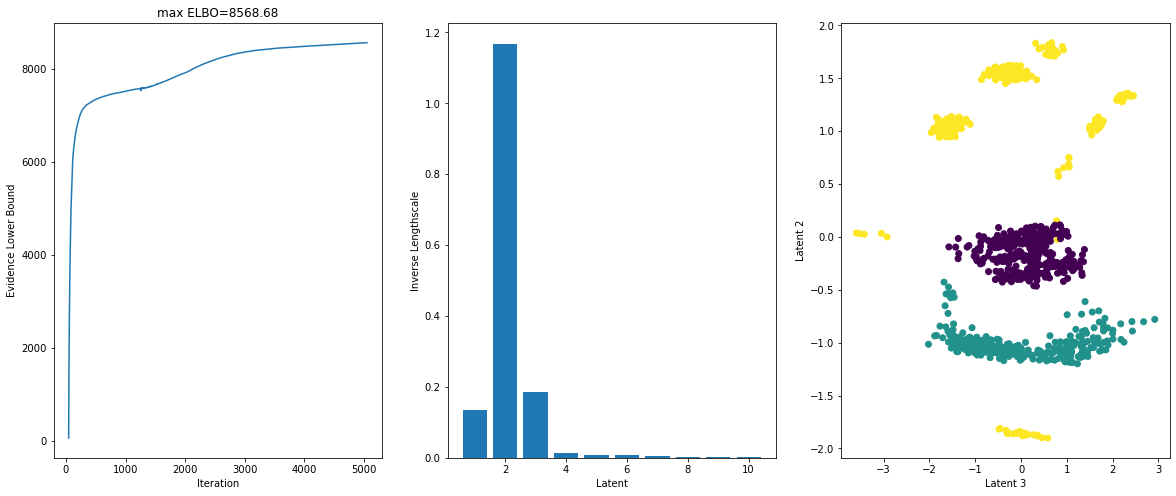

In [11]:
fig_title_pattern = "max ELBO={:.02f}"                                          
title = fig_title_pattern.format(gplvm.elbo())

plt.figure(figsize=(20, 8))

plt.subplot(131)
plt.plot(elbo_list)
plt.xlabel("Iteration")
plt.ylabel("Evidence Lower Bound")
plt.title(title)

lengthscales = gplvm.kernel.base_kernel.lengthscale.detach().numpy().squeeze()
plt.subplot(132)
plt.bar(np.arange(len(lengthscales))+1, 1./lengthscales)
plt.xlabel("Latent")
plt.ylabel("Inverse Lengthscale")

latents_to_plot = np.argsort(lengthscales)[:2]
variational_means = gplvm.variational_mean.detach().numpy()[:,latents_to_plot]

plt.subplot(133)
plt.scatter(variational_means[:,1], variational_means[:,0], c=labels)
plt.xlabel("Latent {:d}".format(latents_to_plot[1]+1))
plt.ylabel("Latent {:d}".format(latents_to_plot[0]+1))